In [36]:

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

In [37]:
mails = pd.read_csv('spam.csv', encoding = 'latin-1')
mails.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [38]:
mails.rename(columns = {'type': 'labels', 'text': 'message'}, inplace = True)
mails.head()

,labels,message
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [39]:
mails['labels'].value_counts()

ham     4812
spam     747
Name: labels, dtype: int64

In [40]:

mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})
mails.head()

,labels,message,label
0,ham,Hope you are having a good week. Just checking in,0
1,ham,K..give back my thanks.,0
2,ham,Am also doing in cbe only. But have to pay.,0
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000...",1
4,spam,okmail: Dear Dave this is your final notice to...,1


In [41]:
mails.drop(['labels'], axis = 1, inplace = True)
mails.head()

,message,label
0,Hope you are having a good week. Just checking in,0
1,K..give back my thanks.,0
2,Am also doing in cbe only. But have to pay.,0
3,"complimentary 4 STAR Ibiza Holiday or Â£10,000...",1
4,okmail: Dear Dave this is your final notice to...,1


In [42]:

totalMails = 4812 + 747
trainIndex, testIndex = list(), list()
for i in range(mails.shape[0]):
    if np.random.uniform(0, 1) < 0.75:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = mails.loc[trainIndex]
testData = mails.loc[testIndex]

In [43]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

,message,label
0,Hope you are having a good week. Just checking in,0
1,K..give back my thanks.,0
2,Am also doing in cbe only. But have to pay.,0
3,"complimentary 4 STAR Ibiza Holiday or Â£10,000...",1
4,okmail: Dear Dave this is your final notice to...,1


In [44]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()

,message,label
0,Sure thing big man. i have hockey elections at...,0
1,Darren was saying dat if u meeting da ge den w...,0
2,So what did the bank say about the money?,0
3,Well if I'm that desperate I'll just call arma...,0
4,Ok.ok ok..then..whats ur todays plan,0


In [45]:

trainData['label'].value_counts()

0    3617
1     557
Name: label, dtype: int64

In [46]:
testData['label'].value_counts()

0    1195
1     190
Name: label, dtype: int64

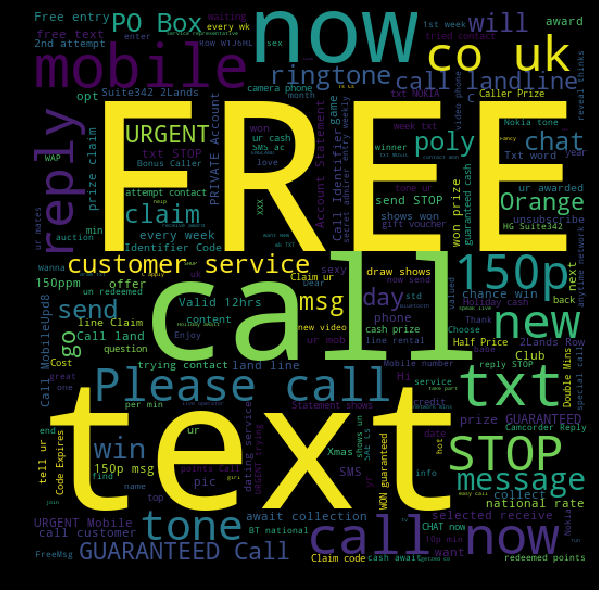

In [47]:
spam_words = ' '.join(list(mails[mails['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

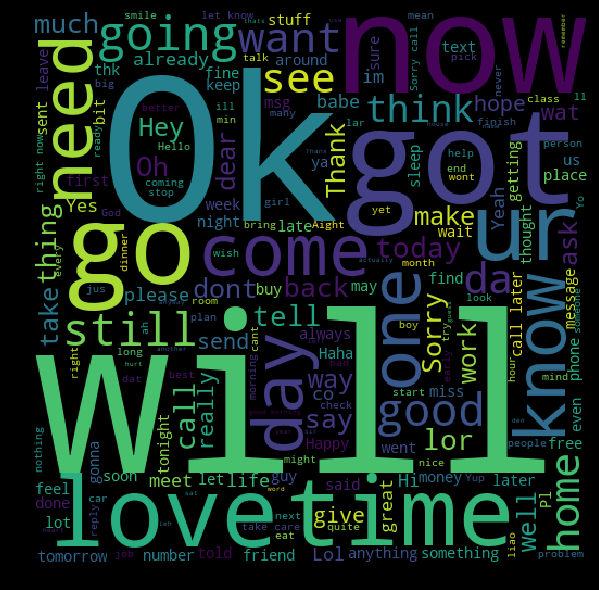

In [48]:

ham_words = ' '.join(list(mails[mails['label'] == 0]['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [49]:
trainData.head()

,message,label
0,Hope you are having a good week. Just checking in,0
1,K..give back my thanks.,0
2,Am also doing in cbe only. But have to pay.,0
3,"complimentary 4 STAR Ibiza Holiday or Â£10,000...",1
4,okmail: Dear Dave this is your final notice to...,1


In [50]:
trainData['label'].value_counts()

0    3617
1     557
Name: label, dtype: int64

In [51]:
testData.head()

,message,label
0,Sure thing big man. i have hockey elections at...,0
1,Darren was saying dat if u meeting da ge den w...,0
2,So what did the bank say about the money?,0
3,Well if I'm that desperate I'll just call arma...,0
4,Ok.ok ok..then..whats ur todays plan,0


In [52]:
testData['label'].value_counts()

0    1195
1     190
Name: label, dtype: int64

In [53]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [54]:

class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [55]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [56]:
sc_tf_idf = SpamClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.9197080291970803
Recall:  0.6631578947368421
F-score:  0.7706422018348624
Accuracy:  0.9458483754512635


In [57]:
sc_bow = SpamClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.905982905982906
Recall:  0.5578947368421052
F-score:  0.6905537459283387
Accuracy:  0.9314079422382672


In [62]:
pm = process_message('I wil call you later')
sc_tf_idf.classify(pm)

False

In [60]:
pm = process_message('Umma my life and vava umma love you lot dear')
sc_tf_idf.classify(pm)

False